# Predictive Modeling For Ebook Best Sellers: Attempts in Machine Learning


```
I came across this dataset on Kaggle and, without thinking much, decided to try some models to predict BestSellers, focusing mainly in the features isKindleUnlimited,isGoodReadsChoice and isEditorsPick.

The only goal was to practice, so I turned a blind eye to a few things. You can follow my entire line of thought in this notebook.

Anyway, this was a cool little job to practice data preparation, exploratory analysis and look for patterns and relationships between features.
After that, I tried logistic regression, decision tree and random forest. Due to issues in the data quality, the results were not satisfactory.
I decided to keep the models anyway, just to document my approach. Maybe in the future I'll decide to dedicate a few more hours to this notebook, but for now it's time to move on to another project.

Please note that I don't know how accurate is this database.
```



#**1 - GETTING STARTED**

**1.1 Loading the dataset**

In [58]:
# import the dataset
from google.colab import files
uploaded = files.upload()


Saving kindle_data-v2.csv to kindle_data-v2.csv


In [59]:
# Store the dataset in a pandas dataframe
import io, pandas as pd
df = pd.read_csv(io.BytesIO(uploaded['kindle_data-v2.csv']))
# df.head(3)

**1.2 Import packages**

Note: pandas already imported in the cell above

In [60]:
# Data manipulation
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# Displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# Data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

# Metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, \
roc_auc_score, roc_curve
from sklearn.tree import plot_tree

# To deal with warnings
import warnings

# Saving models
import pickle

#**2 - EXPLORATORY DATA ANALYSIS**

**2.1 Getting familiar with the dataset**

In [61]:
# Get an overview of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133102 entries, 0 to 133101
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   asin               133102 non-null  object 
 1   title              133102 non-null  object 
 2   author             132677 non-null  object 
 3   soldBy             123869 non-null  object 
 4   imgUrl             133102 non-null  object 
 5   productURL         133102 non-null  object 
 6   stars              133102 non-null  float64
 7   reviews            133102 non-null  int64  
 8   price              133102 non-null  float64
 9   isKindleUnlimited  133102 non-null  bool   
 10  category_id        133102 non-null  int64  
 11  isBestSeller       133102 non-null  bool   
 12  isEditorsPick      133102 non-null  bool   
 13  isGoodReadsChoice  133102 non-null  bool   
 14  publishedDate      84086 non-null   object 
 15  category_name      133102 non-null  object 
dtypes:

In [62]:
# Drop irrelevant columns: asin, imgUrl, productURL, category_id (category_name is enough)
df.drop(['asin', 'imgUrl','productURL'], axis=1, inplace=True)

# Display the first three rows
df.head(3)

,title,author,soldBy,stars,reviews,price,isKindleUnlimited,category_id,isBestSeller,isEditorsPick,isGoodReadsChoice,publishedDate,category_name
0,Adult Children of Emotionally Immature Parents...,Lindsay C. Gibson,Amazon.com Services LLC,4.8,0,9.99,False,6,True,False,False,2015-06-01,Parenting & Relationships
1,"From Strength to Strength: Finding Success, Ha...",Arthur C. Brooks,Penguin Group (USA) LLC,4.4,0,16.99,False,6,False,False,False,2022-02-15,Parenting & Relationships
2,Good Inside: A Guide to Becoming the Parent Yo...,Becky Kennedy,HarperCollins Publishers,4.8,0,16.99,False,6,False,True,False,2022-09-13,Parenting & Relationships


Everything seems to make sense in terms of datatypes.

**2.2 Check missing values**

In [63]:
# Check if there are missing values
df.isna().sum()


title                    0
author                 425
soldBy                9233
stars                    0
reviews                  0
price                    0
isKindleUnlimited        0
category_id              0
isBestSeller             0
isEditorsPick            0
isGoodReadsChoice        0
publishedDate        49016
category_name            0
dtype: int64

In [64]:
# Calculate the percentage of missing data in each column
missing_data = df.isnull().sum() / len(df) * 100

# Print the result
print(missing_data)

title                 0.000000
author                0.319304
soldBy                6.936785
stars                 0.000000
reviews               0.000000
price                 0.000000
isKindleUnlimited     0.000000
category_id           0.000000
isBestSeller          0.000000
isEditorsPick         0.000000
isGoodReadsChoice     0.000000
publishedDate        36.825893
category_name         0.000000
dtype: float64


There's a lot of missing data in the "publishedDate" column, a considerable amount for "soldBy" and a few values for "author". As this is a project for practice only and the two columns with high number of missing values possibly won't be important for this study, I will ignore these values.

Below you can see how I would replace the missing values in the first two with the mode (most frequent value) and drop the rows with missing "author", if this were the chosen approach.

Let's call this edited dataframe "df_1", but it won't be used after that.

In [65]:
# How I would replace the missing values if I decided to approach them this way.
# Copy the dataframe and give this copy a new name

df1 = df.copy()

# Calculate the mode of the columns
soldBy_mode = df1['soldBy'].mode()[0]
publishedDate_mode = df1['publishedDate'].mode()[0]

# Replace missing values with the mode
df1['soldBy'].fillna(soldBy_mode, inplace=True)
df1['publishedDate'].fillna(publishedDate_mode, inplace=True)

# Drop the missing values in author
df1.dropna(subset=['author'], inplace=True)

# Check the changes
df1.isna().sum()

title                0
author               0
soldBy               0
stars                0
reviews              0
price                0
isKindleUnlimited    0
category_id          0
isBestSeller         0
isEditorsPick        0
isGoodReadsChoice    0
publishedDate        0
category_name        0
dtype: int64

**2.3 Check duplicates**

In [66]:
# Check for duplicates (should return 0 if there are no duplicates)
df.duplicated().sum()


1

In [67]:
# Display every instance of duplicate rows (that's why 'keep=False')
duplicates = df[df.duplicated(keep=False)]
duplicates

,title,author,soldBy,stars,reviews,price,isKindleUnlimited,category_id,isBestSeller,isEditorsPick,isGoodReadsChoice,publishedDate,category_name
123816,Climate Change Law (Concepts and Insights),Daniel A. Farber,Amazon.com Services LLC,5.0,0,42.75,False,20,False,False,False,NaN,Law
124127,Climate Change Law (Concepts and Insights),Daniel A. Farber,Amazon.com Services LLC,5.0,0,42.75,False,20,False,False,False,NaN,Law


In [68]:
# Drop duplicate
df = df.drop_duplicates()

# Check if the duplicate was removed
df.duplicated().sum()

0

**2.4 Exploring variables**

In [69]:
# Check distributions of the variables with boolean values

print(df["isBestSeller"].value_counts())
print("\n------------------------\n")
print(df["isEditorsPick"].value_counts())
print("\n------------------------\n")
print(df["isGoodReadsChoice"].value_counts())
print("\n------------------------\n")
print(df["isKindleUnlimited"].value_counts())



isBestSeller
False    130865
True       2236
Name: count, dtype: int64

------------------------

isEditorsPick
False    127480
True       5621
Name: count, dtype: int64

------------------------

isGoodReadsChoice
False    131699
True       1402
Name: count, dtype: int64

------------------------

isKindleUnlimited
False    97286
True     35815
Name: count, dtype: int64


In [70]:
# Identify subset of data that are True to isBestSeller,isEditorsPick,isGoodReadsChoice and is isKindleUnlimited
all_true_df = df[(df['isBestSeller'] == True) & (df['isEditorsPick'] == True) & (df['isEditorsPick'] == True) \
                   & (df['isGoodReadsChoice'] == True) & (df['isKindleUnlimited'] == True )]

print(all_true_df)


Empty DataFrame
Columns: [title, author, soldBy, stars, reviews, price, isKindleUnlimited, category_id, isBestSeller, isEditorsPick, isGoodReadsChoice, publishedDate, category_name]
Index: []


The dataframe is empty - in all the 130000 rows, there is not a single book that checks True for all these tags. Interesting.

Now let's check if there are rows negative for isBestSeller but positive for the other three tags.

In [71]:
print(df[(df['isBestSeller'] == False) & (df['isEditorsPick'] == True) & (df['isEditorsPick'] == True) \
                   & (df1['isGoodReadsChoice'] == True) & (df['isKindleUnlimited'] == True )])


Empty DataFrame
Columns: [title, author, soldBy, stars, reviews, price, isKindleUnlimited, category_id, isBestSeller, isEditorsPick, isGoodReadsChoice, publishedDate, category_name]
Index: []


Still empty.
Let's go on and leave this for later.



**2.5 Check outliers**

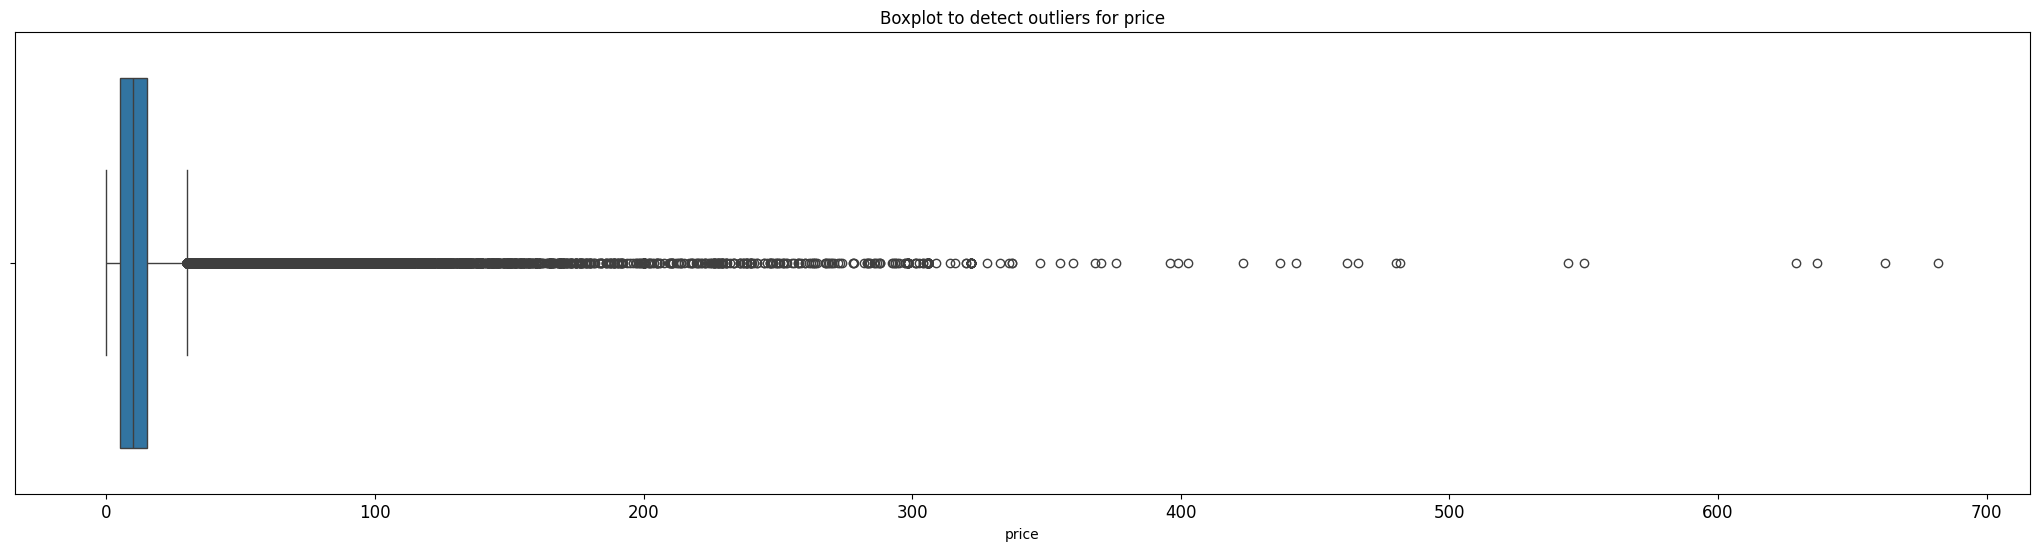

In [72]:
# Create a boxplot to visualize distribution of 'price' and detect any outliers
plt.figure(figsize=(26,6))
plt.title('Boxplot to detect outliers for price', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=df['price'])
plt.show()

The boxplot shows there are outliers. Let's investigate these rows.

In [73]:
# Determine the number of rows containing outliers

# Compute the 25th percentile value in 'price'
percentile25 = df['price'].quantile(0.25)

# Compute the 75th percentile value in 'price'
percentile75 = df['price'].quantile(0.75)

# Compute the interquartile range in 'price'
iqr = percentile75 - percentile25

# Define upper limit and lower limit for non-outlier values in 'price'
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

print("Lower limit:", lower_limit)
print("Upper limit:", upper_limit)

# Identify subset of data containing outliers in 'price'
outliers = df[(df['price'] > upper_limit) | (df['price'] < lower_limit)]

# Count how many rows in the data contain outliers in 'price'
print("Number of rows in the data containing outliers in 'price':", len(outliers))

# Calculate the perfect of 'price' outliers in df1
print(f"Percentage of price outliers in df: {len(outliers)/len(df)*100}%")

Lower limit: -10.01
Upper limit: 29.990000000000002
Number of rows in the data containing outliers in 'price': 13490
Percentage of price outliers in df: 10.135160517201223%


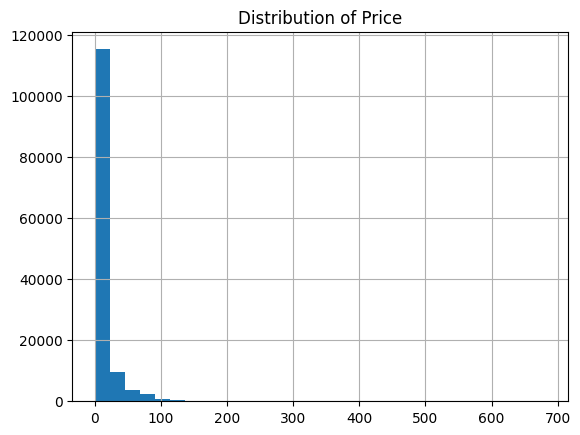

In [74]:
# Plot the histogram for price
df['price'].hist(bins=30)
plt.title('Distribution of Price', fontsize=12)
plt.show()

This is not a normal distribution.
Let's take a look into the extreme outliers.

In [75]:
# Take a look into the rows with high prices
df[(df['price'] > 150)].head(5)


,title,author,soldBy,stars,reviews,price,isKindleUnlimited,category_id,isBestSeller,isEditorsPick,isGoodReadsChoice,publishedDate,category_name
1695,Domestic Violence: Legal and Social Reality (A...,D. Kelly Weisberg,Amazon.com Services LLC,3.9,0,298.30,False,6,False,False,False,NaN,Parenting & Relationships
5284,Advanced Engineering Mathematics,Dennis G. Zill,Amazon.com Services LLC,4.5,0,218.36,False,11,False,False,False,2020-12-01,Engineering & Transportation
5486,Project Resource Manual The CSI Manualof Pract...,The Construction Specifications Institute,Amazon.com Services LLC,4.7,0,217.49,False,11,False,False,False,2004-10-07,Engineering & Transportation
5617,Applications of Turbulent and Multiphase Combu...,Kenneth Kuan-yun Kuo,JOHN WILEY AND SONS INC,0.0,0,166.00,False,11,False,False,False,2012-07-17,Engineering & Transportation
5838,Antiviral and Antimicrobial Coatings Based on ...,Shahid Ul Islam,Amazon.com Services LLC,0.0,0,308.75,False,11,False,False,False,2023-06-15,Engineering & Transportation


E-books for more than a $ 150? I thought they would be typos, but after some googling somehow they seem legit prices. Additionaly, based on their titles, they're all technical books.

Now check outliers in the column 'reviews'

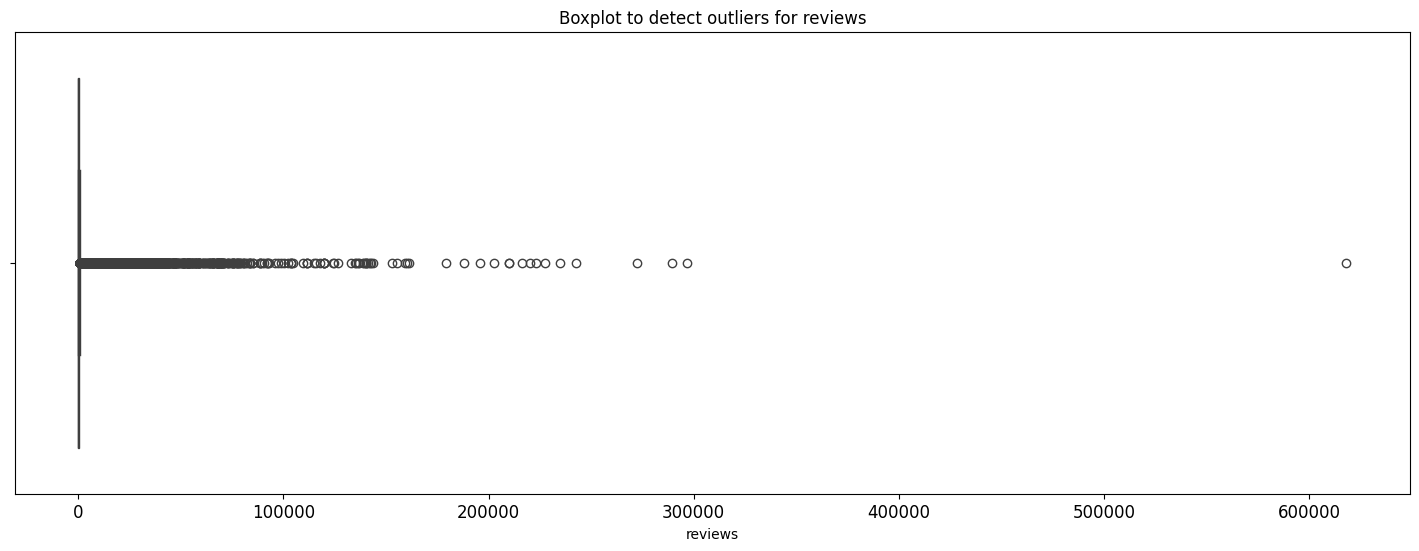

In [76]:
# Create a boxplot to visualize distribution of 'reviews' and detect any outliers
plt.figure(figsize=(18,6))
plt.title('Boxplot to detect outliers for reviews', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=df['reviews'])
plt.show()

Most of the reviews are clustered in the low end. But there are definetely lots outliers and also extreme outliers.

In [77]:
# Determine the number of rows containing outliers

# Compute the 25th percentile value in 'reviews'
percentile25 = df['reviews'].quantile(0.25)

# Compute the 75th percentile value in 'reviews'
percentile75 = df['reviews'].quantile(0.75)

# Compute the interquartile range in 'reviews'
iqr = percentile75 - percentile25

# Define upper limit and lower limit for non-outlier values in 'reviews'
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

print("Lower limit:", lower_limit)
print("Upper limit:", upper_limit)

# Identify subset of data containing outliers in 'reviews'
outliers = df[(df['reviews'] > upper_limit) | (df['reviews'] < lower_limit)]

# Count how many rows in the data contain outliers in 'reviews'
print("Number of rows in the data containing outliers in 'reviews':", len(outliers))

# Calculate the percent of 'reviews' outliers in df1
print(f"Percentage of 'reviews' outliers in df: {len(outliers)/len(df)*100}%")

Lower limit: -547.5
Upper limit: 912.5
Number of rows in the data containing outliers in 'reviews': 20876
Percentage of 'reviews' outliers in df: 15.68432994492904%


Let's check if the outliers are best sellers.

isBestSeller
False    97.552213
True      2.447787
Name: proportion, dtype: float64


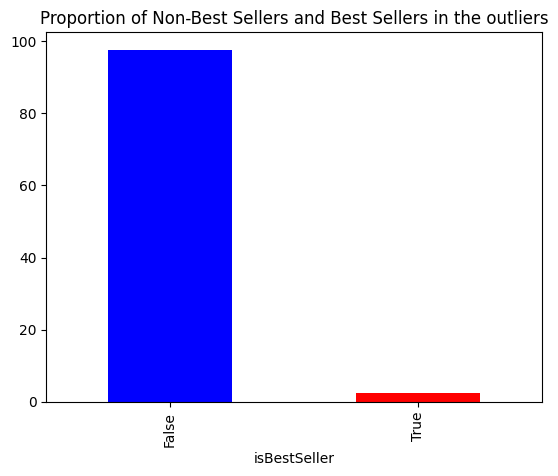

In [78]:
# Check the distribution of best sellers in the outliers
outliers_value_counts = outliers["isBestSeller"].value_counts(normalize=True)*100
print(outliers_value_counts)

# Plot a bar chart of the results
outliers_value_counts.plot(kind='bar', color=["b","r"])
plt.title('Proportion of Non-Best Sellers and Best Sellers in the outliers', fontsize=12)
plt.show()


This is... intriguing. I was imagining that a good part of the books with more reviews would be best sellers. But giving it a second thought, maybe a good part of these reviews are negative.

Let's check the book with highest number of reviews.

In [79]:
# Display the row that has the highest number of reviews
outliers[outliers["reviews"] == outliers["reviews"].max()]

,title,author,soldBy,stars,reviews,price,isKindleUnlimited,category_id,isBestSeller,isEditorsPick,isGoodReadsChoice,publishedDate,category_name
28874,Where the Crawdads Sing,Delia Owens,Penguin Group (USA) LLC,4.7,618227,12.99,False,5,False,True,False,2018-08-14,Literature & Fiction


Not a BestSeller. Could the 618,227 reviews be a typo?

It is a EditorsPick, though.

Let's check the top 10 books with more reviews.

In [80]:
# Get the rows with the 10 highest numbers of reviews

df1.sort_values(by='reviews', ascending=False).head(10)

,title,author,soldBy,stars,reviews,price,isKindleUnlimited,category_id,isBestSeller,isEditorsPick,isGoodReadsChoice,publishedDate,category_name
28874,Where the Crawdads Sing,Delia Owens,Penguin Group (USA) LLC,4.7,618227,12.99,False,5,False,True,False,2018-08-14,Literature & Fiction
28628,It Ends with Us: A Novel,Colleen Hoover,Simon and Schuster Digital Sales Inc,4.7,296710,11.99,False,5,False,False,True,2023-09-12,Literature & Fiction
28641,The Nightingale: A Novel,Kristin Hannah,Macmillan,4.7,289251,11.99,False,5,False,True,False,2015-02-03,Literature & Fiction
30579,"The Silent Patient: The record-breaking, multi...",Alex Michaelides,Amazon.com Services LLC,4.4,272608,0.00,False,5,False,True,False,2019-02-05,Literature & Fiction
28634,Reminders of Him: A Novel,Colleen Hoover,Amazon.com Services LLC,4.7,242575,5.99,True,5,False,True,False,2022-01-18,Literature & Fiction
28654,The Midnight Library: A Novel,Matt Haig,Penguin Group (USA) LLC,4.3,234933,13.99,False,5,False,True,False,2020-09-29,Literature & Fiction
28816,Eleanor Oliphant Is Completely Fine: A Novel,Gail Honeyman,Penguin Group (USA) LLC,4.5,227722,1.99,False,5,False,False,True,2017-05-09,Literature & Fiction
29130,Beneath a Scarlet Sky: A Novel,Mark Sullivan,Amazon.com Services LLC,4.6,223114,2.99,True,5,False,False,True,2017-05-01,Literature & Fiction
28602,Lessons in Chemistry: A Novel,Bonnie Garmus,Random House LLC,4.6,219990,14.99,False,5,False,True,False,2022-04-05,Literature & Fiction
28693,All the Light We Cannot See: A Novel,Anthony Doerr,Simon and Schuster Digital Sales Inc,4.5,216532,13.99,False,5,False,True,False,2014-05-06,Literature & Fiction


None of the top 10 books with more reviews has the isBestSeller tag. Reviews don't seem a good predictor of this tag.

Other observations: they all have at least one of the other tags, they're all under the category of Literature & Fiction and all of them cost less than 15 dollars.

Next: Explore the stars category





In [81]:
# Get the descriptive statistics for 'stars'
print(df["stars"].describe())

count    133101.000000
mean          4.404086
std           0.745647
min           0.000000
25%           4.400000
50%           4.500000
75%           4.700000
max           5.000000
Name: stars, dtype: float64


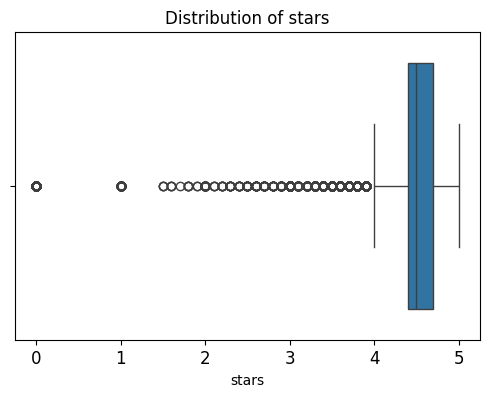

In [82]:
# Create a boxplot to visualize the distribution of 'stars'
plt.figure(figsize=(6,4))
plt.title('Distribution of stars', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=df['stars'])
plt.show()

Most ratings are clustered between 4 and 5 stars, which explains the high mean (4,40).

**2.6 Feature Engineering**

Let's create a new boolean column called OtherTag, combining all the other labels except isBestSeller, and a numeric column 'Sum_Other_Tags', with the sum of other tags of that row.

In [83]:
# Combine the boolean columns (except isBestSeller) into a new column called 'OtherTag'
df['OtherTag'] =  df['isKindleUnlimited'] | df1['isEditorsPick'] | df['isGoodReadsChoice']

# Create a column 'Sum_Other_Tags with the sum of the tags'.
df['Sum_Other_Tags'] = df['isKindleUnlimited'] + df1['isEditorsPick'] + df['isGoodReadsChoice']

# Display the three first rows
df.head(3)

# Confirm datatypes
# df.info()



,title,author,soldBy,stars,reviews,price,isKindleUnlimited,category_id,isBestSeller,isEditorsPick,isGoodReadsChoice,publishedDate,category_name,OtherTag,Sum_Other_Tags
0,Adult Children of Emotionally Immature Parents...,Lindsay C. Gibson,Amazon.com Services LLC,4.8,0,9.99,False,6,True,False,False,2015-06-01,Parenting & Relationships,False,0
1,"From Strength to Strength: Finding Success, Ha...",Arthur C. Brooks,Penguin Group (USA) LLC,4.4,0,16.99,False,6,False,False,False,2022-02-15,Parenting & Relationships,False,0
2,Good Inside: A Guide to Becoming the Parent Yo...,Becky Kennedy,HarperCollins Publishers,4.8,0,16.99,False,6,False,True,False,2022-09-13,Parenting & Relationships,True,1


#**3 - DATA VISUALIZATION**

**3.1 Visualize the tag columns**

Take a look into the relationships between the more interesting variables in the dataset

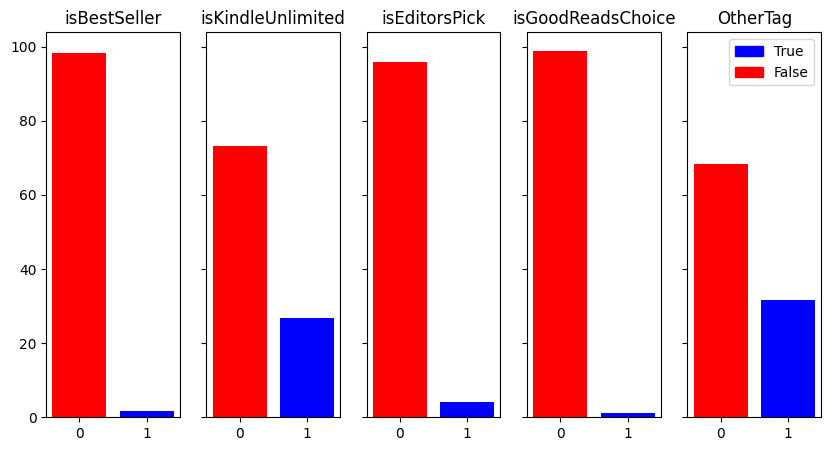

In [84]:
# Get the distribution of best sellers
best_seller_counts = df["isBestSeller"].value_counts(normalize=True)*100

# Get the distribution of Kindle Unlimited
kindle_counts = df["isKindleUnlimited"].value_counts(normalize=True)*100

# Get the distribution of EditorsPick
editors_counts = df["isEditorsPick"].value_counts(normalize=True)*100

# Get the distribution of GoodReadsChoice
goodreads_counts = df["isGoodReadsChoice"].value_counts(normalize=True)*100

# Get the distribution of OtherTag
othertag_counts = df["OtherTag"].value_counts(normalize=True)*100

# Plot a bar chart of the results
fig, axs = plt.subplots(1, 5, figsize=(10, 5), sharey=True)

# Plot data
axs[0].bar(range(len(best_seller_counts)), best_seller_counts,color=["r","b"])
axs[1].bar(range(len(kindle_counts)), kindle_counts,color=["r","b"])
axs[2].bar(range(len(editors_counts)), editors_counts,color=["r","b"])
axs[3].bar(range(len(goodreads_counts)), goodreads_counts,color=["r","b"])
axs[4].bar(range(len(othertag_counts)), othertag_counts,color=["r","b"])

# Set titles
axs[0].set_title('isBestSeller')
axs[1].set_title('isKindleUnlimited')
axs[2].set_title('isEditorsPick')
axs[3].set_title('isGoodReadsChoice')
axs[4].set_title('OtherTag')

# Create legend handles
true_patch = mpatches.Patch(color='b', label='True')
false_patch = mpatches.Patch(color='r', label='False')

# Add legend to plot
plt.legend(handles=[true_patch, false_patch])



isBestSeller is the second label that appears least in the dataset.
Other Tag accepts any value other than isBestSeller, so it makes sense that it would be the column with more positive classes

Let's transform the code above in a helper function in case you need to use it often.

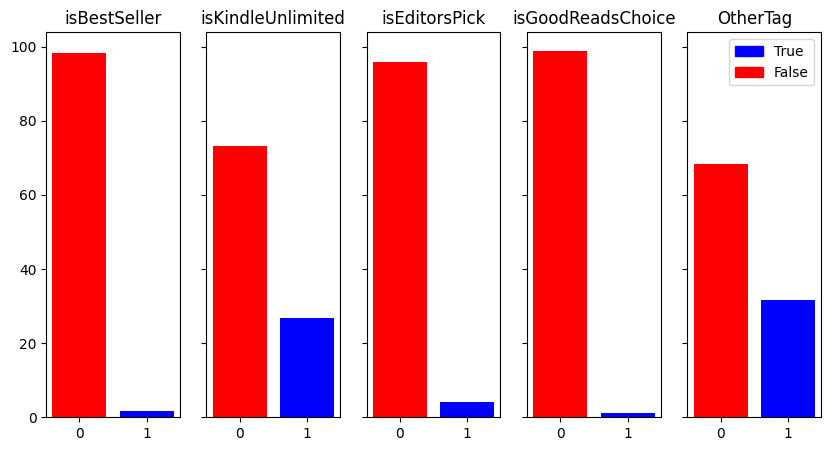

In [85]:
def plot_distribution(df, columns):
  """ Takes a dataframe and a list of its columns and returns a plot with the percentage of their values """
  #Create a subplot for each column
  fig, axs = plt.subplots(1, len(columns), figsize=(10, 5), sharey=True)

  for i, column in enumerate(columns):
    # Get the distribution of the column (%)
    column_counts = df[column].value_counts(normalize=True) * 100

    # Create a color map: True is blue, False is red
    colors = ['b' if index else 'r' for index in column_counts.index]

    # Plot a bar chart of the results
    axs[i].bar(range(len(column_counts)), column_counts, color=colors)

    # Set title
    axs[i].set_title(column)

  # Create legend handles
  true_patch = mpatches.Patch(color='b', label='True')
  false_patch = mpatches.Patch(color='r', label='False')

  # Add legend to plot
  plt.legend(handles=[true_patch, false_patch])

  # Show the plot
  plt.show()

# Test if the function works:
columns=["isBestSeller","isKindleUnlimited","isEditorsPick","isGoodReadsChoice","OtherTag"]
plot_distribution(df,columns)

Create a subset with only the rows where isBestSeller is True and plot the same graph.

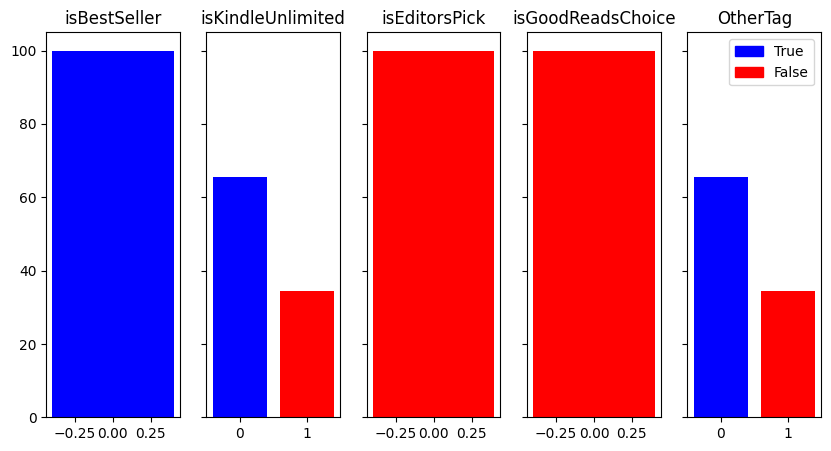

In [86]:
# Create a subset with only rows that are best sellers
bestsellers_df = df[df["isBestSeller"]==True]

# Use the helper function to plot the graph with the percentages
columns=["isBestSeller","isKindleUnlimited","isEditorsPick","isGoodReadsChoice","OtherTag"]
plot_distribution(bestsellers_df,columns)


This is a revelation that impacts this study. There are no books tagged as Best Seller & as EditorsPick or as GoodReadsChoice. The features created won't help in terms of predicting the positive class (isBestSeller).

**3.2 Explore other visualizations**

Text(0.5, 1.0, 'Number of Reviews by Price')

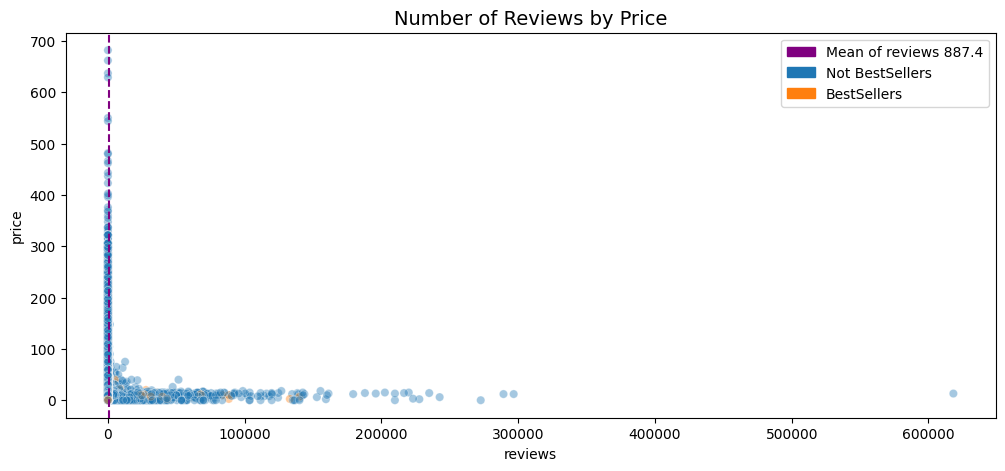

In [87]:
# Create scatterplot of number of 'reviews' versus 'price', comparing best sellers and non-best sellers

# Get mean of reviews
mean_reviews = df["reviews"].mean()
mean_price = df["price"].mean()
# print(mean_price)

# Prepare the graph
plt.figure(figsize=(12, 5))
sns.scatterplot(data=df, x='reviews', y='price', hue='isBestSeller', alpha=0.4)
plt.axvline(x=mean_reviews, color='#800080', label='Mean', ls='--')

# Horizontal line that I left out of the code
# plt.axhline(y=mean_price, color='#000000', label='mean_price', ls='--')

# Create custom handles for the legend
handles = [mpatches.Patch(color='#800080', label='Mean of reviews {:.1f}'.format(mean_reviews)),
           mpatches.Patch(color=sns.color_palette()[0], label='Not BestSellers'),
           mpatches.Patch(color=sns.color_palette()[1], label='BestSellers')]

plt.legend(handles=handles)
plt.title('Number of Reviews by Price', fontsize='14')

The scatterplot above shows confirms that the books with more reviews are not necessarily best sellers. However, there are groups of best sellers with more reviews than the mean of number of reviews.

Aditionally, the mean of 'price' is 15.13, but there are no groups of bestsellers above $100.

I also plotted a horizontal line with the mean of price, but the graph is already polluted without it, so I left it out.

**3.3 Check for strong correlations between variables in the data.**

A heatmap can be used to check the correlation of interesting features.


Note 1: I wrote a code that converts Boolean values ​​into numeric values, in case these were problems, but it was not necessary. I ended up leaving them commented out to use in the future if necessary.

Note 2: There's also the 'category_name' and its numerical version 'category_id', but even the latter would require encoding (since it is just a representation of a categorical feature). I tried a version  of the model with this feature, but the results were pretty much the same, so I discarded it. I've also kept the code for one-hot encoding it just in case, but commented it out.

In [88]:
# Create a copy of the dataframe and call it df2
df2 = df.copy()

# Drop the columns that won't be used.
df2.drop(['title', 'author','category_id','category_name','soldBy','publishedDate','OtherTag','Sum_Other_Tags'],axis=1, inplace=True)

# Convert the boolean columns to numeric.
#df2['isBestSeller'] = df2['isBestSeller'].astype(int)
#df2['isKindleUnlimited'] = df2['isKindleUnlimited'].astype(int)
#df2['isEditorsPick'] = df2['isEditorsPick'].astype(int)
#df2["isGoodReadsChoice"] = df2["isGoodReadsChoice"].astype(int)

# One-hot encode the 'category_name' column
# df2 = pd.get_dummies(df2, columns=['category_name'])

# Confirm changes
df2.head(2)
# df2.dtypes

,stars,reviews,price,isKindleUnlimited,isBestSeller,isEditorsPick,isGoodReadsChoice
0,4.8,0,9.99,False,True,False,False
1,4.4,0,16.99,False,False,False,False


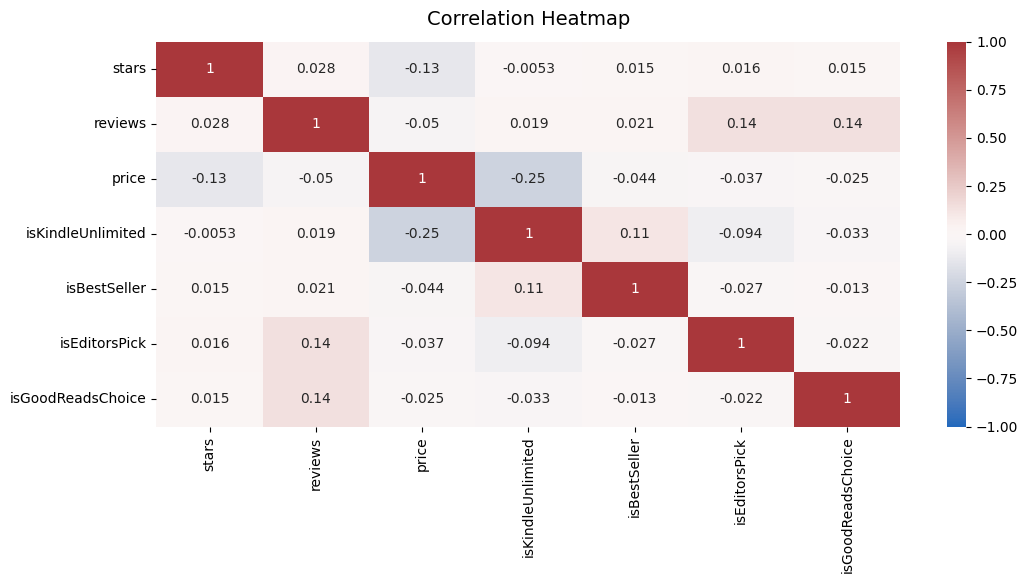

In [89]:
# Calculate correlation matrix
corr_matrix = df2.corr()

# Plot a heatmap
plt.figure(figsize=(12, 5))
heatmap = sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);
plt.show()

From this map, it is possible to see that the correlation between the features is weak.
The highest correlation are between reviews and EditorsPick and reviews and GoodReadsChoice (0.14). BestSellers and KindleUnlimited have a correlation of 0.11, and the correlation between BestSellers and the other tags (EditorsPick and GoodReads Choice) is slightly negative (-0.027 and -0.013).

The relationship between BestSeller and the number of reviews and star rating is positive, but very low (0.021 and 0.015, respectively).

Out of curiosity, the most negative relationship is KindleUnlimited and Price. Well, KindleUnlimited is a subscription program where customers can read eBooks for a monthly subscription fee.

#**4 - MODELING**

##**4.1 LOGISTIC REGRESSION**

**4.1.1 Check assupmtions for logistic regression model**

Since this will be a binary classification model, logistic regression seems a good choice, but there are some assumptios that should be met:

• Independent observations: How the data was collected. Let's assume this is not a problem.

• Little to no multicollinearity among X predictors: The values are low in the heatmap, so this assumption is met.

• Linear relationship between X and the logit of y: This will be verified later, when the model is ready.

• No extreme outliers: this is a problem, Logistic regression models are sensitive to extreme outliers. At least the 'review' column have some values that fall into that category. Let's go back to it and also check again 'price'.

In [90]:
# Check the descriptive statistics of 'reviews' and 'price'
df2[["reviews","price"]].describe()

,reviews,price
count,133101.000000,133101.000000
mean,887.382446,15.133920
std,5104.897374,22.254941
min,0.000000,0.000000
25%,0.000000,4.990000
50%,4.000000,9.990000
75%,365.000000,14.990000
max,618227.000000,682.000000


The maximum value for number of reviews is 618,227, while 75% of the observations are equal to or fall under 365.

For 'price' the maximum value is 682, while 75% of the observations are equal to or fall under $14.99.

These would be great indications that there are extreme outliers, but more precise values were already calculated in the section 2.5.

Below and above the limits, an observation is considered an outlier:

*Price:*

Lower limit: -10.01

Upper limit: 29.990000000000002

Number of rows in the data containing outliers in 'price': 13,490

Percentage of price outliers in df: 10.135160517201223%

*Reviews*:

Lower limit: -547.5

Upper limit: 912.5

Number of rows in the data containing outliers in 'reviews': 20,876

Percentage of 'reviews' outliers in df: 15.68432994492904%


**4.1.2 Approach the extreme outliers**

Let's try to impute the outlying values for these columns: take the 94th percentile value and use it to replace any value above it.

In [91]:
# Impute outliers
df2[["price","reviews"]].quantile(0.95)
for column in ['reviews','price']:
  threshold = df2[column].quantile(0.95)
  df2.loc[df[column] > threshold, column] = threshold

# Check again
df2[["reviews","price"]].describe()

,reviews,price
count,133101.000000,133101.000000
mean,457.312657,13.219528
std,932.754446,12.231360
min,0.000000,0.000000
25%,0.000000,4.990000
50%,4.000000,9.990000
75%,365.000000,14.990000
max,3565.000000,50.880000


The upper limit for not being considered an outlier was calculated at 912. We now have at least one observation with 3,565 reviews. It still looks extreme, but much better. Let's go on and maybe reconsider this value in the future.

**4.1.3 - Model building**

Assign predictor variables (X) and target (y).
df2.head(1)

In [92]:
# Isolate the predictors and call them X
X = df2.drop(['isBestSeller'],axis=1)

# Isolate the target and call it y
y = df2["isBestSeller"]

# Confirm X
# X.head(1)

# Confirm y
y.head(1)


0    True
Name: isBestSeller, dtype: bool

Split the data into test and train sets using scikit-learn’s train_test_split().

The target class (isBestSeller) is imbalanced, so let's use the stratify parameter to be sure that the minority class (True) appears in both
sets in the right proportion (as in the complete dataset).

Use random_state=14 for reproducibility purposes and select the test_size as 25%.

In [93]:
# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=14)

Instatiate the model.
Use the parameter penalty = None, because the predictors are not scaled.


In [94]:
# Iniate the model and fit the data. Let's test 300 iterations.
model = LogisticRegression(random_state=14, max_iter=300)
model.fit(X_train, y_train)

LogisticRegression(max_iter=300, random_state=14)

Check the models .coef_ attribute to get the coefficients of the variables.
The coefficients represent the change in the log odds (the likelyhood of an event) of the target variable for every one unit increase in X.


In [95]:
# Create a series whose index are the predictors and the values are their coefficients
pd.Series(model.coef_[0], index=X.columns)


stars                0.311404
reviews              0.000118
price               -0.035039
isKindleUnlimited    1.354841
isEditorsPick       -1.070665
isGoodReadsChoice   -0.345248
dtype: float64

A positive coefficient (0.317) for stars means that higher star ratings increase the log odds of isBestSeller.
For each unit increase in stars, the odds of isBestSeller increase by approximately (e^{(0.317}). Of course, the range of stars is limited.

The positive coefficient (1.359402) of IsKindleLimited suggests that if the book has this tag like the film (if they valye is True), the odds of book being a bestsellincrease significantly. The odds increase by approximately (e^{1.359402}.
And so it goes.

Let's check the model's intercept (log-odds of the outcome when all predictors are equal to 0 or at their reference level).

In [96]:
#Check the intercept of the model
model.intercept_


array([-5.76452828])

**4.1.4 Check the last assumption**

Verify the linear relationship between X and the logit (log odds) of y.

The model's predict_proba() method to generate the probability of response for each sample in the training data. (The training data is the argument to the method.)

Each row of the array represents one book in X_train. The first column is the probability of not being a bestseller, and the second
column is the probability of being.

In [97]:
# Get the predicted probabilities of the training data
training_probabilities = model.predict_proba(X_train)
training_probabilities

array([[0.99117278, 0.00882722],
       [0.99371889, 0.00628111],
       [0.96074649, 0.03925351],
       ...,
       [0.99291686, 0.00708314],
       [0.95790553, 0.04209447],
       [0.99728062, 0.00271938]])

In logistic regression, the relationship between the log-odds (logit) of the dependent variable with respect to the predictor variable should be linear.


In [98]:
 # Make copy of 'X_train' df and save it as 'logit_data'
logit_data = X_train.copy()

Now let's plot it.

If this were a super complete project, the ideal would be to plot the graph for all variables. But I'll do just one. Since I just want to practice, I would even violate assumptions to continue, to be honest.

In [99]:
# Create a 'logit' column in the 'logit_data' df
logit_data['logit'] = [np.log(prob[1] / prob[0]) for prob in training_probabilities]

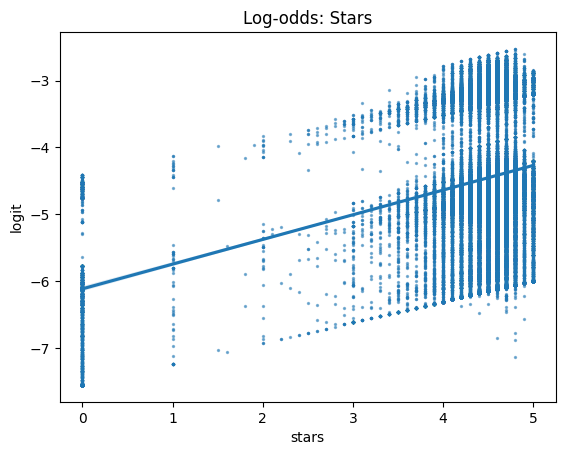

In [100]:
# Plot regplot of 'stars' log-odds
sns.regplot(x='stars', y='logit', data=logit_data, scatter_kws={'s': 2,'alpha': 0.5})
plt.title('Log-odds: Stars');

 The overall trend is linear, but data points also deviate from this line

**4.1.5 Results and Model Evaluation**

Make predictions on the test data

In [101]:
# Make predictions using the test data
y_pred = model.predict(X_test)

Accuracy measures the proportion of data points correctly predicted (True Positives + True negatives / Total predictions).

Scikit-learn has a method that by default gives the accuracy: '.score'
Let's check the accuracy on the test data.

In [102]:
# Check the model accuracy on the test data
model.score(X_test, y_test)

0.9832011059021517

98% is interesting, but it can be misleading if the dataset is imbalanced or if the model overfits.

As a next step, a Confusion Matrix could to visualize the True Positives, True Negatives, False Positives and False Negatives.

Let's use y_test and y_pred as arguments in the confusion_matrix function.

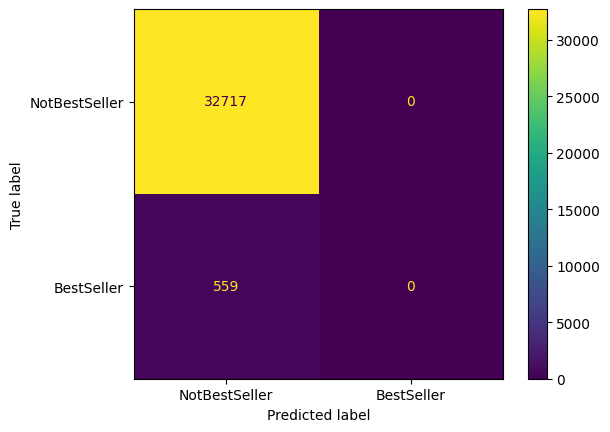

In [103]:
# Generate a Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Display the Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
display_labels=['NotBestSeller', 'BestSeller'])
disp.plot()

Note: Scikit-learn plots the Confusion Matrix as:

TN - FP

FN - TP

The Upper left is the number for True Negatives. The model correctly predicted 32717 data points that are not BestSellers. The upper right tells us that the model predicted 0 False Positives.

The lower left is the number for False Negatives - when the model predicts a negative outcome, but the actual outcome is positive. So 559 best sellers were actuacly misclassified as not best sellers.

The lower left is the number of True Positives, which is disappointing.

Let's double-check the numbers using the methor cm.ravel()

In [104]:
# Extract TN, FP, FN, TP
tn, fp, fn, tp = cm.ravel()
print(tn, fp, fn, tp)

32717 0 559 0


Same numbers! But they don't look good.
Let's check the value counts in the isBestSeller column.
metrics.

In [105]:
# Check the balance
df2['isBestSeller'].value_counts(normalize=True)

isBestSeller
False    0.983201
True     0.016799
Name: proportion, dtype: float64

The value_counts of notBestSeller is equal to the Accuracy (98.32%), which suggests that the model is making predictions based solely on the majority class (the most frequent class). It seems that the model may not be learning meaningful patterns and might not work well to unseen data.

**4.1.6 Evaluating the Logistic Regression Model**

Next step: creating a classification report, a performance evaluation metric that gives us the following:

Precision: correct positive predictions relative to total positive predictions.

Recall: correct positive predictions relative to total actual positives.

F1-score: A weighted harmonic mean of precision and recall.

Support: The number of instances in each class.

In [107]:
# Create a classification report
target_labels = ['NotBestSeller', 'BestSeller']
print(classification_report(y_test, y_pred, target_names=target_labels))

               precision    recall  f1-score   support

NotBestSeller       0.98      1.00      0.99     32717
   BestSeller       0.00      0.00      0.00       559

     accuracy                           0.98     33276
    macro avg       0.49      0.50      0.50     33276
 weighted avg       0.97      0.98      0.97     33276



Overall the model deals really well with NotBestSellers and terribly with BestSellers. This is not a model to rely on, since the goal was to correctly predict BestSellers

Note: I tried the paramenter class_weight='balanced' in the LogisticRegression, but the results were also not good in terms of correctly predicting True values for isBestSeller.

##**4.2 - TREE-BASED MODELS**

Let's try Decision Tree and Random Forest.

**4.2.1 Preparing and selecting data**

In [108]:
# Create new copy of the original dataframe and call it df_trees
df_trees = df.copy()

# Encode category_name (drop argument as 'first' to remove redundant columns from the output.)
df_trees['category_name'] = OneHotEncoder(drop='first').fit_transform(df_trees[['category_name']]).toarray()

# Confirm changes
df_trees['category_name'].head(2)

0    0.0
1    0.0
Name: category_name, dtype: float64

In [109]:
# Isolate the outcome variable
y = df_trees['isBestSeller']

df_trees.head(2)

# Select the predictors (this time without removing category_name)
X = df_trees.drop(['title', 'author','soldBy','category_id','isBestSeller','publishedDate','OtherTag','Sum_Other_Tags'],axis=1)
X.head(2)

,stars,reviews,price,isKindleUnlimited,isEditorsPick,isGoodReadsChoice,category_name
0,4.8,0,9.99,False,False,False,0.0
1,4.4,0,16.99,False,False,False,0.0


Split the data into training and testing sets.

In [110]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,stratify=y, random_state=5)


###**4.2.2 Decision Tree**

Construct a decision tree model with cross-validated grid-search to find the best model parameters.


In [111]:
# Instantiate the model
tree = DecisionTreeClassifier(random_state=5)

# Assign a dictionary of hyperparameters to search over, let's try a mix of numbers
cv_params = {'max_depth':[3, 25, 40, None],
'min_samples_leaf': [5, 20, 50, 100],
'min_samples_split': [5,10, 40, 80, 120]
}
# Assign a dictionary of scoring metrics
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Instantiate GridSearch, cv (the number of folds) as 8 as first atempt
# dt_clf for decision tree classifier
dt_clf = GridSearchCV(tree, cv_params, scoring=scoring, cv=8, refit='roc_auc')

Fit the decision tree model to the training data.

Note: I was receiving a warning saying that precision is ill-defined and being set to 0.0 due to no predicted samples. As the warning is now noted here, I'm ignoring it in the next cell.

In [112]:
%%time

# Ignore warnings for the next line of code cell.
warnings.filterwarnings('ignore')

# Fit the decision tree model to the training data.
dt_clf.fit(X_train, y_train)

# Reset warnings to default
warnings.filterwarnings('default')

CPU times: user 2min 14s, sys: 186 ms, total: 2min 14s
Wall time: 2min 15s


Identify and save the best values for the decision tree parameters

In [113]:
# Check best parameters
dt_best_params = dt_clf.best_params_
dt_best_params

{'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 5}

Identify the best AUC score achieved by the model on the training set. The AUC score is an indicator that measures the model's ability to correctly predict classes.



In [114]:
# Check best AUC score on CV
dt_clf.best_score_


0.7366834226107852

AUC score of 1 is the maximum score. At first sight, 0.73 looks acceptable. But we've already received a warning mentioning no predicted samples.


Just for practice, let's keep going.

Use the fitted model to make predictions on the test set, then get the other scores (Accuracy, Precision, F1 and Recall) and also the AUC on the test data.

In [116]:
# Make predictions
y_pred = dt_clf.predict(X_test)

# Calculate Accuracy, Precision, F1 and Recall
dt_accuracy = accuracy_score(y_test, y_pred)
dt_precision = precision_score(y_test, y_pred)
dt_f1 = f1_score(y_test, y_pred)
dt_recall = recall_score(y_test, y_pred)

# Print them
print(f'Precision: {dt_precision}')
print(f'Recall: {dt_recall}')
print(f'F1 Score: {dt_f1}')
print(f'Accuracy: {dt_accuracy}')

# Calculate AUC using the probability estimates of the positive class
y_pred_proba = dt_clf.predict_proba(X_test)[:, 1]
dt_auc = roc_auc_score(y_test, y_pred_proba)

# Print AUC
print(f'AUC: {dt_auc}')
print('---------------------------')

Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Accuracy: 0.9832011059021517
AUC: 0.7440140286928564
---------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision, recall and F1 are all zero, which means the model is not predicting the positive class (isBestSeller=True) properly). I may need to address class imbalance and try it again.

Let's create and display the confusion matrix, just to reinforce visually what's not working.


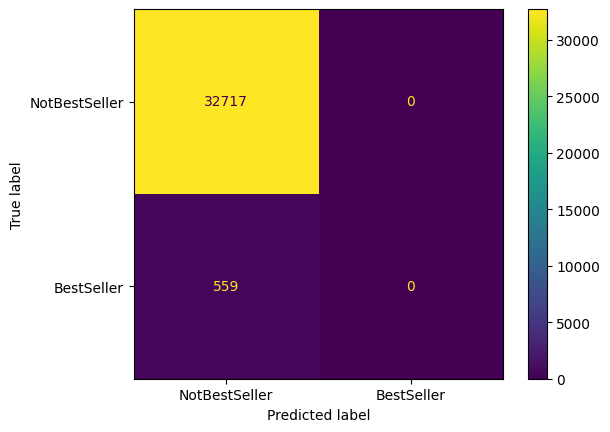

In [117]:
# Generate a Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Display the Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
display_labels=['NotBestSeller', 'BestSeller'])
disp.plot()

Remembering: Top Left represents True Negatives and Bottom Left represents False Negatives.

So it's only the values ​​predicted to be negative that push the AUC and accuracy up.

###**4.2.3 Random Forest**

Create a random forest model and find the best model parameters setting up cross-validated grid-search.

Random forest models use multiple trees to make predictions, so they will deal better with overfitting, if that's the case.

In [118]:
# Instantiate model
rf = RandomForestClassifier(random_state=10)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [3,5],
'max_features': [1.0], # All features will be considered.
'max_samples': [0.5, 0.7, 0.9],
'min_samples_leaf': [1,2,3],
'min_samples_split': [2,4,6],
'n_estimators': [100,150],
}
# Assign a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Instantiate GridSearch
rf1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

Fit the random forest model to the training data.

Note: I was receiving the same warning about precision being ill-defined and being set to 0.0 due to no predicted samples. As the warning is now noted here, I'm ignoring it in the next cell.

Note 2: This may take a several minutes to run.

In [119]:
%%time
# Ignore warnings
warnings.filterwarnings('ignore')

#Fit the model
rf1.fit(X_train, y_train)

# Reset warnings to default
warnings.filterwarnings('default')


CPU times: user 40min 34s, sys: 3.71 s, total: 40min 38s
Wall time: 40min 57s


In [120]:
 # Check best parameters
rf1.best_params_


{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.5,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 100}

In [ ]:
# Check best AUC score on CV
rf1.best_score_

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.7754609495021338

Just like the last model, at first sight the AUC score looks ok: 0.77 actually outperforms the decision tree we tried above. But once again we received a warning mentioning no predicted samples.

Let's keep going, but having that in mind.

Use the fitted model to make predictions on the test set, then get the other scores (Accuracy, Precision, F1 and Recall) and also the AUC on the test data.

In [121]:
# Make predictions
y_pred = rf1.predict(X_test)

# Calculate Accuracy, Precision, F1 and Recall
rf_accuracy = accuracy_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred)
rf_f1 = f1_score(y_test, y_pred)
rf_recall = recall_score(y_test, y_pred)

# Print them
print(f'Precision: {rf_precision}')
print(f'Recall: {rf_recall}')
print(f'F1 Score: {rf_f1}')
print(f'Accuracy: {rf_accuracy}')


# Calculate AUC using the probability estimates of the positive class
y_pred_proba = rf1.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, y_pred_proba)

# Print AUC
print(f'AUC: {rf_auc}')
print('---------------------------')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Accuracy: 0.9832011059021517
AUC: 0.7830318638130663
---------------------------


Precision, Recall, and F1 Score are all 0, which indicates that this model, like the others, is unsuccessful at predicting the positive class, (isBestSeller). Since this was the objective of the project, it is not a valid algorithm at the moment.

It is no secret that the database is very unbalanced. I even tried another round, this time passing the argument "class_weight='balanced'" and hoping that the model would deal better with positives. The results were pretty much the same, so I excluded it.


#**5 - CONCLUSION**


The three models test had similar performances, but didn't perform as expected. Despite having a accuracy of 0.98, they failed to correctly identify BestSeller outcomes (the positive class), scoring 0 for precision, recall and f1. They were excellent at predicting the negative class, but this was not the goal.

On the other hand, at least the exploratory analysis provided some interesting discoveries. The relationship between the isBestSeller tag and the other tags (KindleUnlimited, GoodReadChoices and EditorsPick) is close to zero - the only positive one is with KindleUnlimited, while with the others it is slightly negative

The number of reviews and rating stars are also weak predictive factors. This raises questions about what other types of information the database could include. Here's a little speculation: maybe number of sales, average sales per year since release, investment in marketing and 'isFamousAuthor?'.



